# Analysis

# Time-wise ED Curve

✅ Loaded 1746 valid windows, shape = (1746, 500, 5)


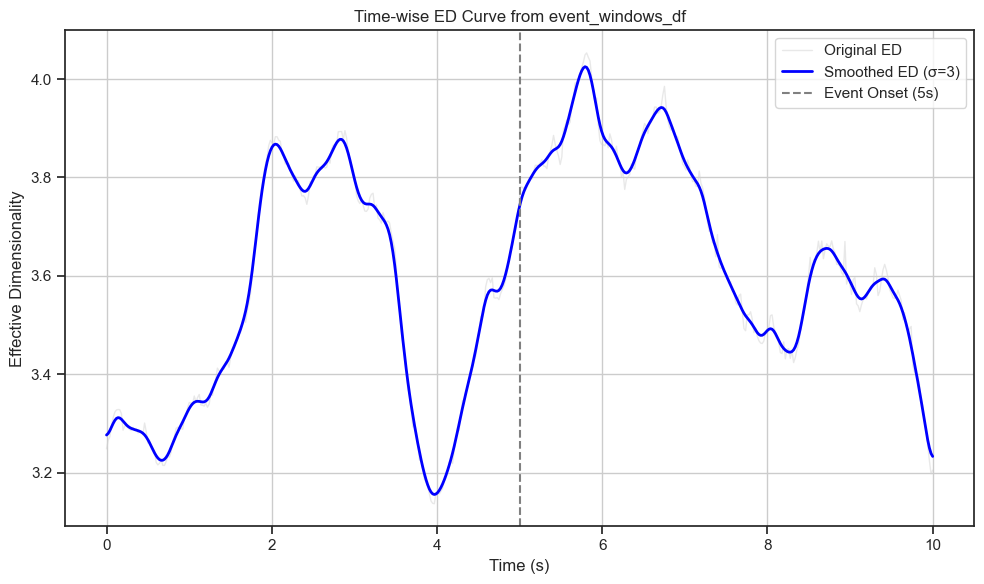

In [1]:
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter1d
# Define dtypes to load all uid files
dtypes = {'uid': 'str','dataset': 'str','city_section': 'str','ExperimentalCondition': 'str','EventName': 'object','HitObjectName': 'object','ObjectName_4': 'object','ObjectName_5': 'object', 'EventDuration': 'float64', 'TimeStamp': 'float64'}
# Define the path to the CSV file
# Use the current working directory
dir = os.getcwd()
# Use glob to find all CSV files in the specified directory
data_path = dir + '/Data/'
# file_path = os.path.join(data_folder, file_name)  # Complete path to the file
# load all data
ddf = dd.read_csv(data_path + '*.csv', assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)

#   Parameters  
modalities = ['NoseVector.x', 'NoseVector.y', 'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'SteeringInput']
points_per_window = 500  # 10 seconds @ 50Hz

#   Load DataFrame  
df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
event_windows_df = df.compute() 

# Convert to pandas for processing
df = df.compute()  # 👈 convert to full pandas DataFrame

#   Check structure  
if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
    raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")

#   Group by each event window  
all_curves = []
grouped = df.groupby(['uid', 'WindowNumber'])

for (uid, window), window_df in grouped:
    if len(window_df) != points_per_window:
        continue  # Skip incomplete windows

    if not all(col in window_df.columns for col in modalities):
        continue

    data = window_df[modalities].values

    # Normalize across modalities within the window
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    all_curves.append(data_scaled)

#   Stack to 3D array: (N_windows, T, M)  
if len(all_curves) == 0:
    raise ValueError("❌ No valid windows found!")

data_array = np.stack(all_curves, axis=0)  # shape: (W, T, M)
W, T, M = data_array.shape
print(f"✅ Loaded {W} valid windows, shape = ({W}, {T}, {M})")

#   Compute Functional Covariance Operator Over Time  
cov_matrix = np.zeros((T, M, M))

for t in range(T):
    snapshot = data_array[:, t, :]  # shape: (W, M)
    centered = snapshot - snapshot.mean(axis=0)
    cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)

#   Compute ED Over Time (Quadratic Entropy)  
ed_curve = []

for t in range(T):
    eigvals = eigh(cov_matrix[t], eigvals_only=True)
    eigvals = np.clip(eigvals, 1e-12, None)
    p = eigvals / np.sum(eigvals)
    ED = 1 / np.sum(p**2)
    ed_curve.append(ED)

#   Smooth the ED Curve  
sigma = 3  # You can adjust this
smoothed_ed = gaussian_filter1d(ed_curve, sigma=sigma)

#   Plot  
seconds = np.linspace(0, 10, T)

plt.figure(figsize=(10, 6))
plt.plot(seconds, ed_curve, color='lightgray', linewidth=1, label='Original ED', alpha=0.5)
plt.plot(seconds, smoothed_ed, color='blue', linewidth=2, label='Smoothed ED (σ=3)')
plt.axvline(5, color='gray', linestyle='--', label='Event Onset (5s)')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.title("Time-wise ED Curve from event_windows_df")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FPCA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

#   Parameters  
modalities = ['NoseVector.x', 'NoseVector.y', 'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'SteeringInput']
points_per_participant = 500  # 10 seconds @ 50Hz
#   Prepare participant windows  
all_participant_curves = []

for (uid, win), sub_df in event_windows_df.groupby(['uid', 'WindowNumber']):
    if len(sub_df) != points_per_participant:
        continue
    if not all(col in sub_df.columns for col in modalities):
        continue

    data = sub_df[modalities].copy()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    all_participant_curves.append(data_scaled.T)

# === Functional Data Setup ===
X = np.stack(all_participant_curves, axis=0)  # (P, M, T)
X = np.transpose(X, (0, 2, 1))                # (P, T, M)
P, T, M = X.shape
X_flat = X.reshape(P, T * M)                  # (P, T*M)
fd = FDataGrid(X_flat, grid_points=np.linspace(0, 1, T * M))

# === FPCA ===
n_components = min(P, 2500)
fpca = FPCA(n_components=n_components)
fpca.fit(fd)

# === Compute Functional ED Curve ===
eigenvalues = fpca.explained_variance_
eigenfunctions = fpca.components_.data_matrix[..., 0]  # shape: (n_components, T*M)

squared = eigenfunctions ** 2
weighted = squared * eigenvalues[:, np.newaxis]
p_t =_


Calculate cumulative amount of variance explained

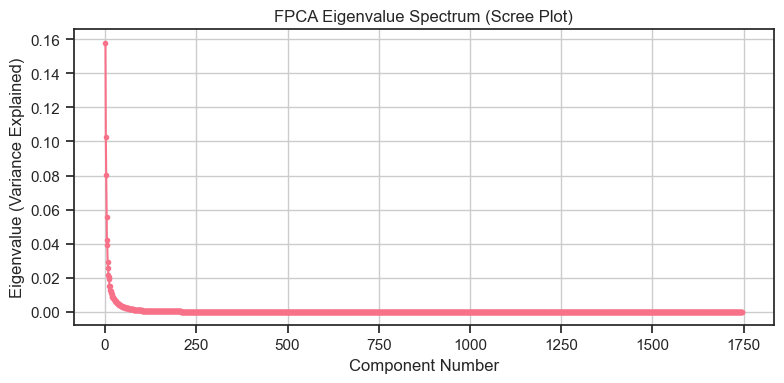

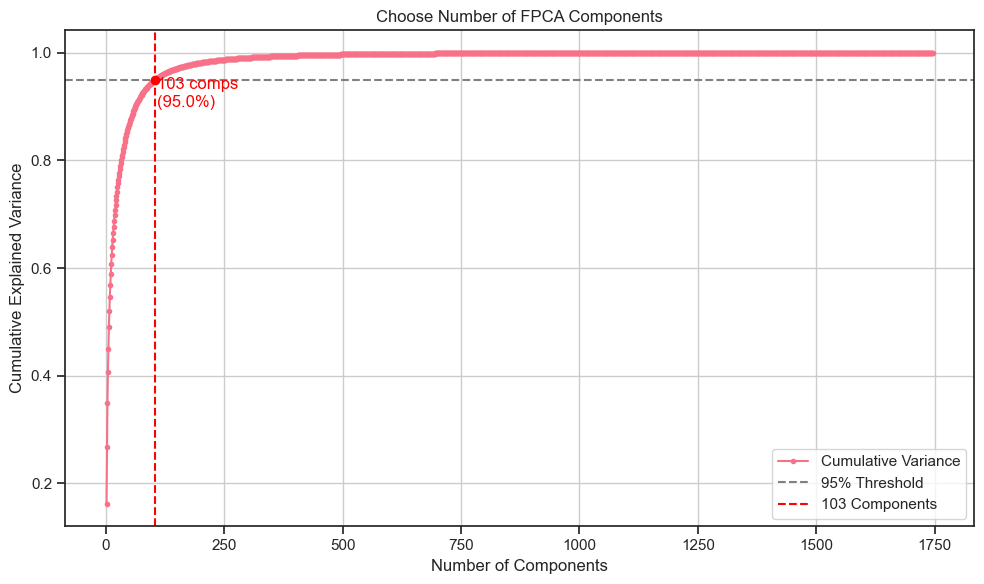

✅ Number of components to reach 95% explained variance: 103


In [6]:


plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, marker='o',markersize=3)
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue (Variance Explained)")
plt.title("FPCA Eigenvalue Spectrum (Scree Plot)")
plt.grid(True)
plt.tight_layout()
plt.show()


################################################v

#   After fitting FPCA with a large number of components  
eigenvalues = fpca.explained_variance_
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

#   Find number of components to reach 90%  
threshold = 0.95
num_components_95 = np.argmax(cumulative_variance >= threshold) + 1  # +1 for 1-based count

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), cumulative_variance, marker='o',markersize=3, label="Cumulative Variance")
plt.axhline(threshold, color='gray', linestyle='--', label='95% Threshold')
plt.axvline(num_components_95, color='red', linestyle='--', label=f'{num_components_95} Components')
plt.scatter(num_components_95, cumulative_variance[num_components_95 - 1], color='red', zorder=5)

# === Annotations ===
plt.text(num_components_95 + 5, cumulative_variance[num_components_95 - 1] - 0.05,
         f"{num_components_95} comps\n({cumulative_variance[num_components_95 - 1]*100:.1f}%)",
         color='red')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Choose Number of FPCA Components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Number of components to reach 95% explained variance: {num_components_95}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

#   Parameters  
modalities = ['NoseVector.x', 'NoseVector.y', 'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'SteeringInput']
points_per_participant = 500  # 10 seconds @ 50Hz


all_participant_curves = []

uids = event_windows_df['uid'].dropna().unique()
for uid in uids:
    df_uid = event_windows_df[event_windows_df['uid'] == uid]
    
    # Chunk into separate event windows of size 500
    n_windows = len(df_uid) // points_per_participant
    for i in range(n_windows):
        start = i * points_per_participant
        end = start + points_per_participant
        segment = df_uid.iloc[start:end]

        if segment.shape[0] != points_per_participant:
            continue
        if not all(col in segment.columns for col in modalities):
            continue

        data = segment[modalities].copy()
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        all_participant_curves.append(data_scaled.T)  # shape: (modalities, time)

#   Convert to Functional Data Object  
if len(all_participant_curves) == 0:
    raise ValueError("❌ No valid participant/event window data found!")

X = np.stack(all_participant_curves, axis=0)  # (P, M, T)
X = np.transpose(X, (0, 2, 1))                # (P, T, M)
P, T, M = X.shape
X_flat = X.reshape(P, T * M)                  # (P, T*M)
fd = FDataGrid(X_flat, grid_points=np.linspace(0, 1, T * M))

#   FPCA  
n_components = min(P, T * M)
fpca = FPCA(n_components=n_components)
fpca.fit(fd)

#   Quadratic Entropy-Based ED (Scalar Only)  
eigenvalues = fpca.explained_variance_
eigenvalues = np.clip(eigenvalues, a_min=1e-12, a_max=None)
p = eigenvalues / np.sum(eigenvalues)
ED_global = 1 / np.sum(p**2)

#   Report  
print(f"✅ Global Scalar ED: {ED_global:.2f} using {len(eigenvalues)} components")


✅ Global Scalar ED: 17.84 using 1746 components


✅ DataFrame shape after filtering: (638500, 90)


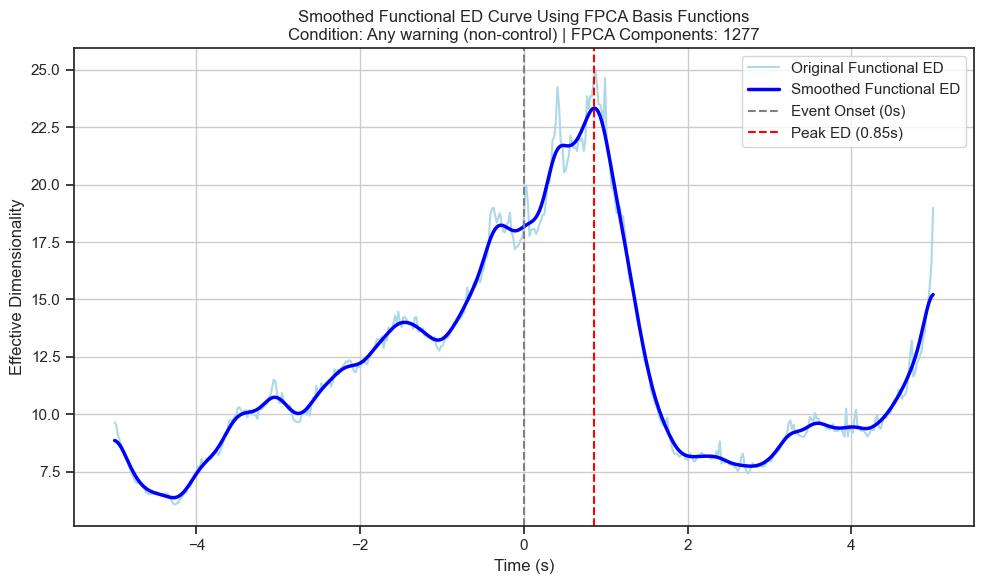

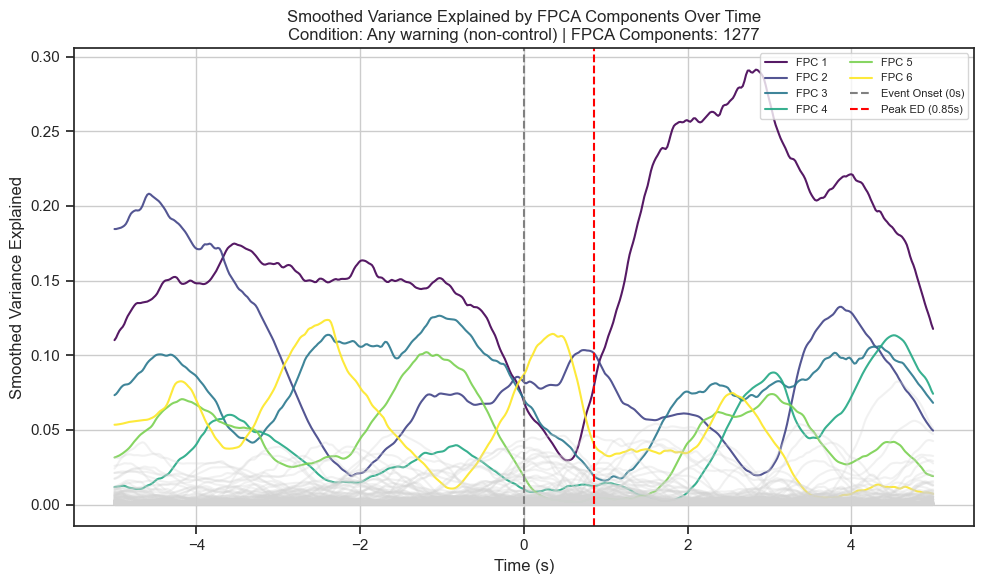

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from scipy.ndimage import gaussian_filter1d

#   Parameters  
modalities = ['NoseVector.x', 'NoseVector.y', 'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'SteeringInput']
points_per_participant = 500  # 10 seconds @ 50Hz
#condition_filter = 'BaseCondition'
condition_filter = '!BaseCondition'
#condition_filter = 'HUDOnly'
#condition_filter = 'AudioOnly'
#condition_filter = 'FullLoopAR'
#condition_filter = 'All Conditions'




#   Filter from in-memory event_windows_df  
df = event_windows_df.copy()


if condition_filter != 'All Conditions': 
    if condition_filter == '!BaseCondition':
        df = df[df['ExperimentalCondition'] != 'BaseCondition']
        condition_filter = "Any warning (non-control)"
    else:
        df = df[df['ExperimentalCondition'] == condition_filter]

print("✅ DataFrame shape after filtering:", df.shape)

#   Aggregate and Normalize per (uid, WindowNumber)  
all_participant_curves = []

for (uid, win), sub_df in df.groupby(['uid', 'WindowNumber']):
    if len(sub_df) != points_per_participant:
        continue
    if not all(col in sub_df.columns for col in modalities):
        continue

    data = sub_df[modalities].copy()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    all_participant_curves.append(data_scaled.T)  # (modalities, time)

#   Convert to Functional Data Object  
if len(all_participant_curves) == 0:
    raise ValueError("❌ No valid participant data found!")

X = np.stack(all_participant_curves, axis=0)  # shape: (P, M, T)
X = np.transpose(X, (0, 2, 1))                # shape: (P, T, M)
P, T, M = X.shape
X_flat = X.reshape(P, T * M)                  # shape: (P, T*M)
fd = FDataGrid(X_flat, grid_points=np.linspace(0, 1, T * M))

#   FPCA  
n_components = min(P, 2500)
fpca = FPCA(n_components=n_components)
fpca.fit(fd)

#   Functional ED Calculation from FPCA  
eigenvalues = fpca.explained_variance_                    # shape: (n_components,)
eigenfunctions = fpca.components_.data_matrix[..., 0]     # shape: (n_components, T*M)
squared = eigenfunctions ** 2
weighted = squared * eigenvalues[:, np.newaxis]
p_t = weighted / np.sum(weighted, axis=0, keepdims=True)
ED_curve = 1 / np.sum(p_t ** 2, axis=0)                   # shape: (T*M,)

#   Reshape to Time and Average Across Modalities  
ED_curve_reshaped = ED_curve.reshape(T, M).mean(axis=1)   # shape: (T,)
seconds = np.linspace(-5, 5, T)

#   Smoothing and Plotting  
smoothed_ED_curve = gaussian_filter1d(ED_curve_reshaped, sigma=5)

# Get the maximum ED value and its corresponding time
peak_value = np.max(smoothed_ED_curve)
peak_index = np.argmax(smoothed_ED_curve)
peak_time = seconds[peak_index]


plt.figure(figsize=(10, 6))
plt.plot(seconds, ED_curve_reshaped, color='lightblue', linewidth=1.5, label='Original Functional ED')
plt.plot(seconds, smoothed_ED_curve, color='blue', linewidth=2.5, label='Smoothed Functional ED')
plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak ED ({peak_time:.2f}s)')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.title(f"Smoothed Functional ED Curve Using FPCA Basis Functions\n"
          f"Condition: {condition_filter} | FPCA Components: {n_components}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# INDIVIDUAL COMPONENTS

from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

highlight_N = 6  # Number of components to color
total_to_plot = min(P, n_components)

# Use colormap for first `highlight_N` components
colors = cm.viridis(np.linspace(0, 1, highlight_N))


squared = eigenfunctions ** 2
weighted_energy = squared * eigenvalues[:, np.newaxis]
normalized_energy = weighted_energy / np.sum(weighted_energy, axis=0, keepdims=True)

# --- Reshape and average across modalities ---
n_components = eigenfunctions.shape[0]
T = 500  # number of time points
M = int(eigenfunctions.shape[1] / T)
energy_time = normalized_energy.reshape(n_components, T, M).mean(axis=2)  # shape: (n_components, T)

# --- Smooth each component's curve ---
sigma = 1  # You can tweak this for more/less smoothing
energy_time_smoothed = np.array([gaussian_filter1d(comp, sigma=sigma) for comp in energy_time])

# --- Plot ---
plt.figure(figsize=(10, 6))

time_sec = np.linspace(0, 10, T)

time_sec = time_sec - 5  # shift so event onset (5s) becomes 0

for i in range(total_to_plot):
    if i < highlight_N:
        plt.plot(time_sec, energy_time_smoothed[i], label=f'FPC {i+1}',
                 color=colors[i], alpha=0.9)
    else:
        plt.plot(time_sec, energy_time_smoothed[i], color='lightgray', alpha=0.3)

plt.xlabel("Time (s)")
plt.ylabel("Smoothed Variance Explained")
plt.title(f"Smoothed Variance Explained by FPCA Components Over Time\n"
          f"Condition: {condition_filter} | FPCA Components: {n_components}")
plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak ED ({peak_time:.2f}s)')

# Legend for colored lines only
plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot the individual FPCA components ± the mean function

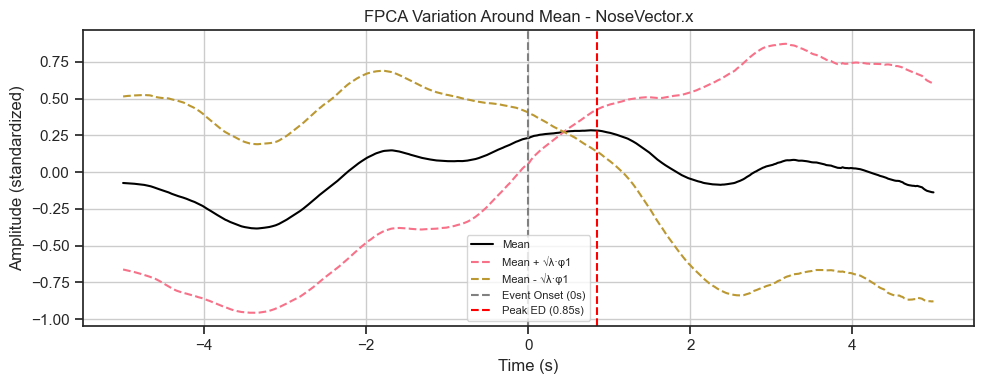

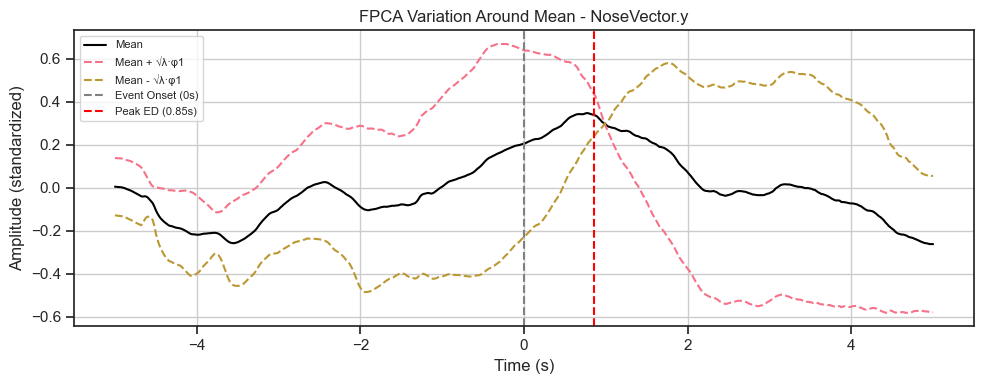

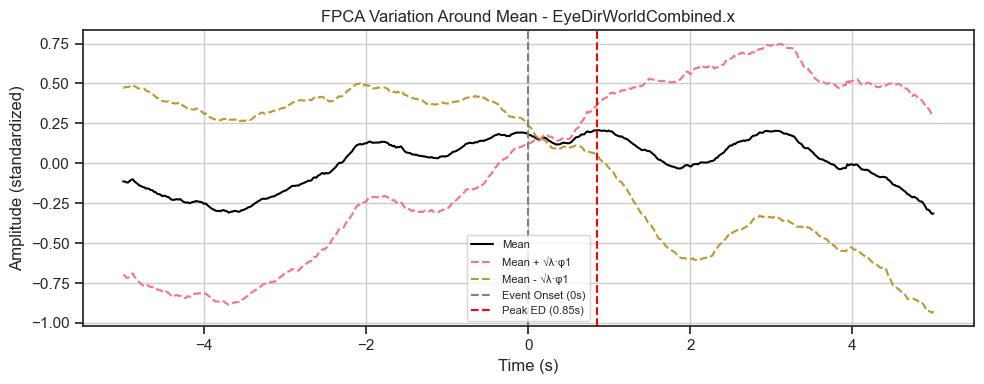

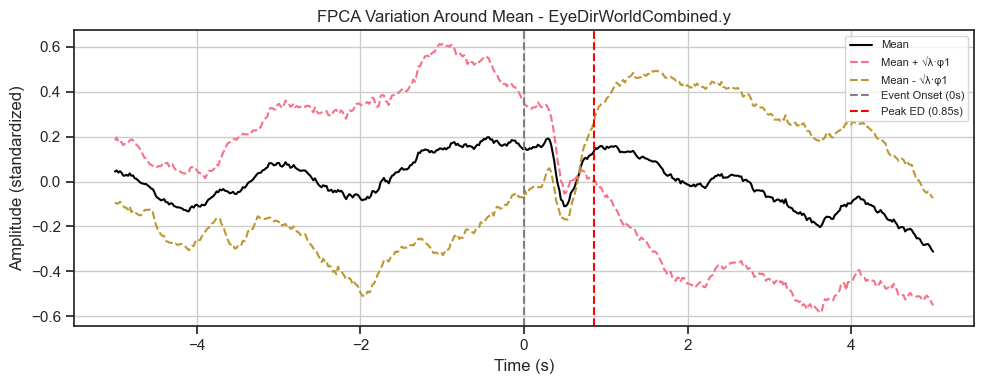

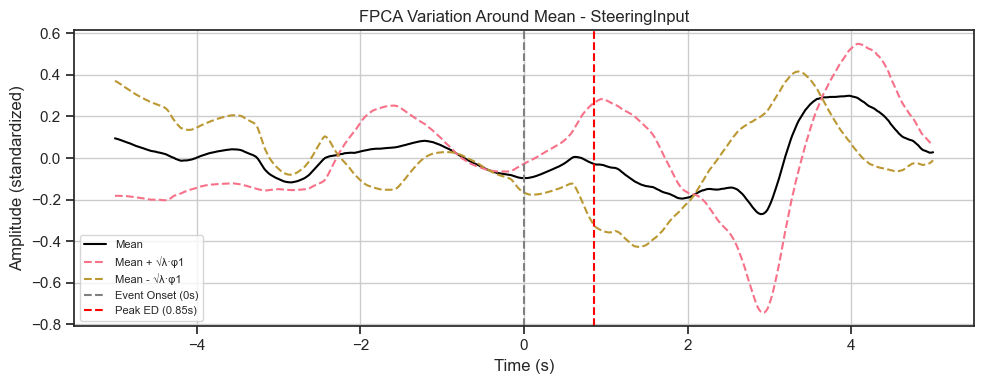

In [21]:
mean_function = fpca.mean_.data_matrix[..., 0]            # shape: (T*M,)
eigenfunctions = fpca.components_.data_matrix[..., 0]     # shape: (n_components, T*M)

mean_function_reshaped = mean_function.reshape(T, M)      # shape: (T, M)
eigenfunctions_reshaped = eigenfunctions.reshape(n_components, T, M)

time = np.linspace(-5, 5, T)
n_show = 1  # Number of components to show

for m, modality in enumerate(modalities):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(time, mean_function_reshaped[:, m], color='black', label='Mean')

    for k in range(n_show):
        # Scale eigenfunction by sqrt of its eigenvalue
        phi = eigenfunctions_reshaped[k, :, m]
        scale = np.sqrt(eigenvalues[k])
        
        ax.plot(time, mean_function_reshaped[:, m] + scale * phi,
                label=f'Mean + √λ·φ{k+1}', linestyle='--')
        ax.plot(time, mean_function_reshaped[:, m] - scale * phi,
                label=f'Mean - √λ·φ{k+1}', linestyle='--')

    ax.set_title(f"FPCA Variation Around Mean - {modality}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (standardized)")
    plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
    plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak ED ({peak_time:.2f}s)')
    ax.legend(fontsize='8', loc='best', frameon=True)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# Plot the Eigenfunctions (FPCA Components) as Time-Modality Heatmaps


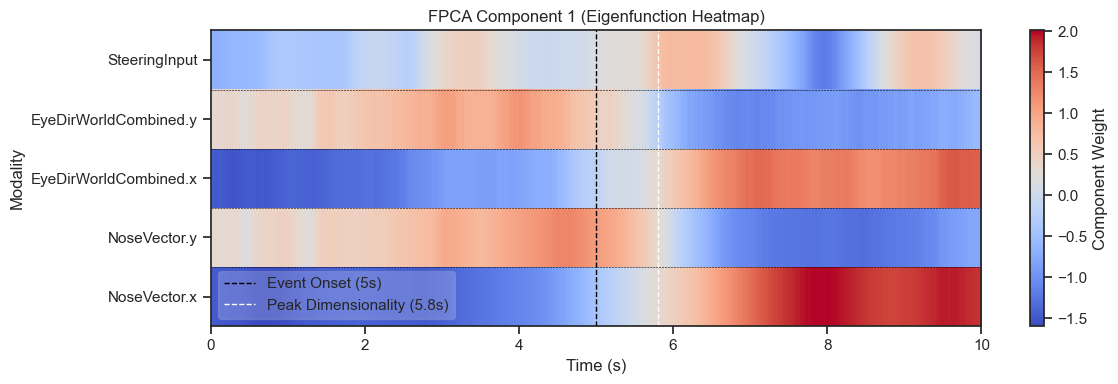

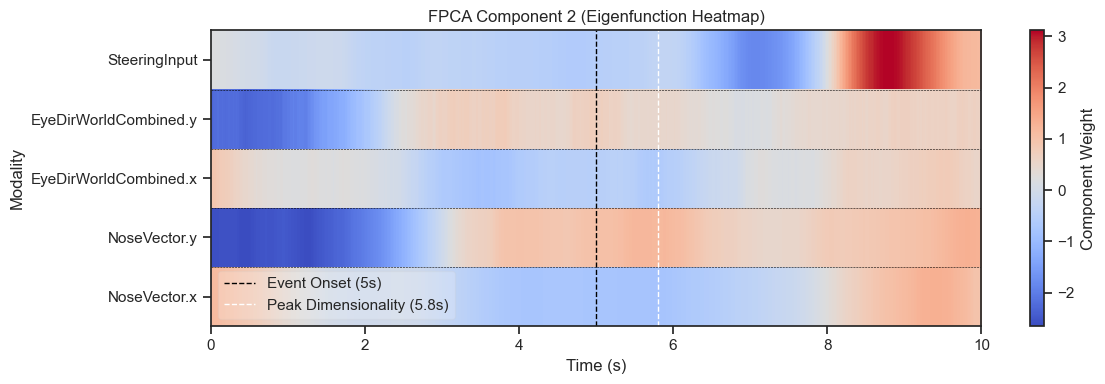

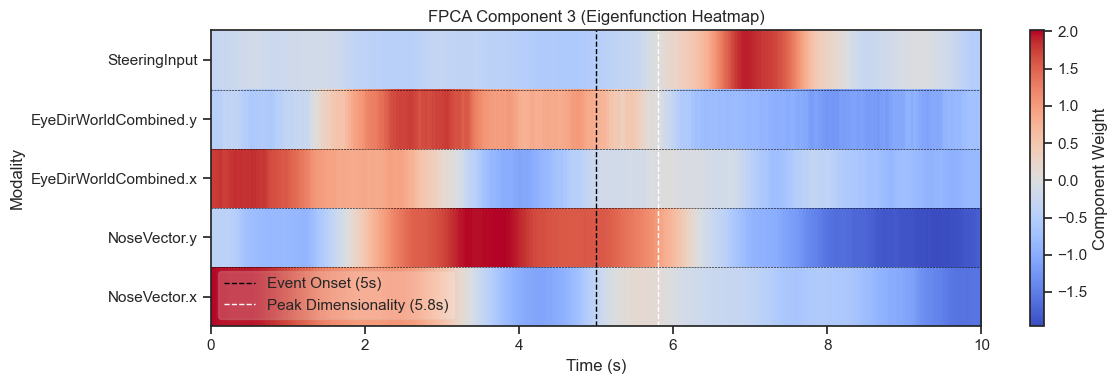

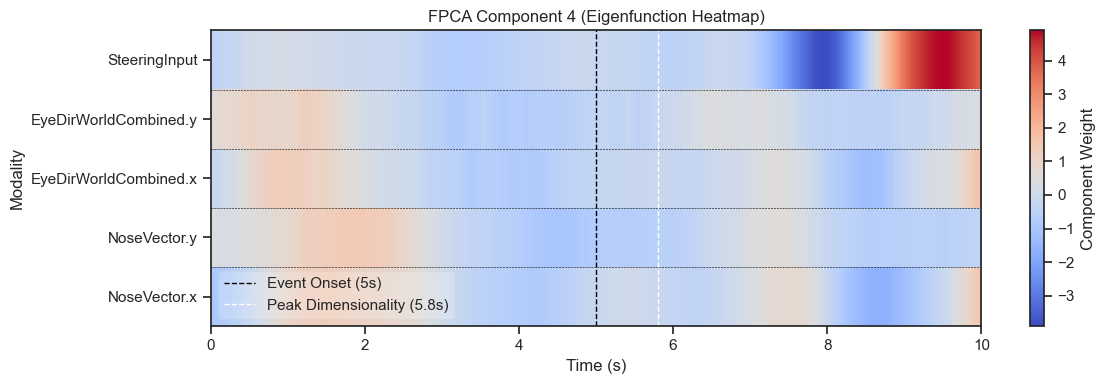

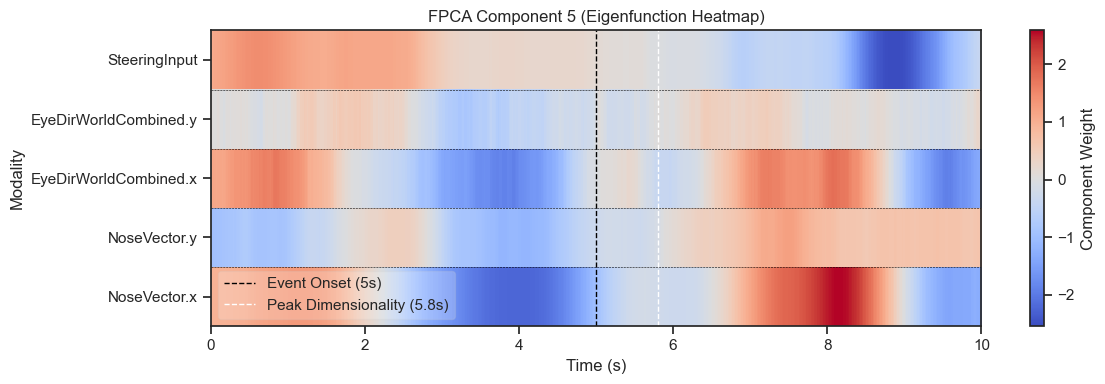

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Parameters ===
T = 500
M = 5
modalities = ['NoseVector.x', 'NoseVector.y', 'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'SteeringInput']
time_sec = np.linspace(0, 10, T)

# === Reshape Eigenfunctions ===
n_components = eigenfunctions.shape[0]
reshaped = eigenfunctions.reshape(n_components, T, M)  # (n_components, T, M)

# === Customize How Many Components to Plot ===
N = 5  # ⬅️ Adjust number of components to visualize

# === Plot ===
for k in range(min(N, n_components)):
    fig, ax = plt.subplots(figsize=(12, 4))
    im = ax.imshow(
        reshaped[k].T,
        aspect='auto',
        cmap='coolwarm',
        extent=[0, 10, 0, M],
        origin='lower',
        interpolation='none'
    )
    cbar = plt.colorbar(im, ax=ax, label='Component Weight')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Modality")
    ax.set_title(f"FPCA Component {k+1} (Eigenfunction Heatmap)")

    # Modality ticks and separators
    ax.set_yticks(np.arange(M) + 0.5)
    ax.set_yticklabels(modalities)
    for y in range(1, M):
        ax.axhline(y=y, color='black', linewidth=0.4, linestyle='--')

    # Event onset line
    ax.axvline(x=5, color='black', linestyle='--', linewidth=1, label='Event Onset (5s)')
    ax.axvline(x=5.8, color='white', linestyle='--', linewidth=1, label='Peak Dimensionality (5.8s)')

    ax.legend(loc='lower left', framealpha =0.2)


    plt.tight_layout()
    plt.show()


# Plot Scores of Participants on the First Few Components

Wider histogram → more variability in the cohort for

Skewed histogram → asymmetric behavior (e.g. most people show the pattern positively)

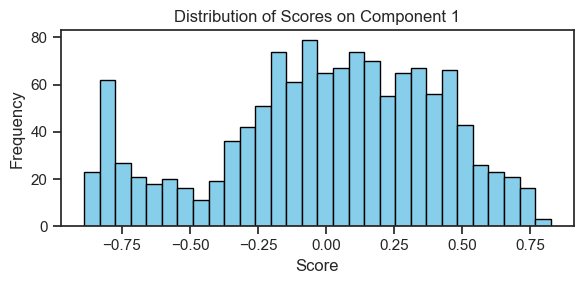

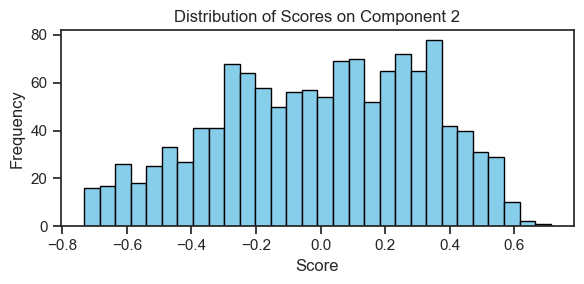

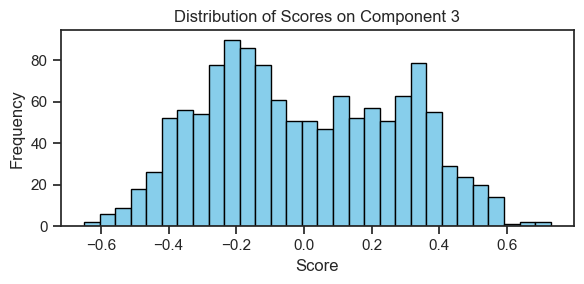

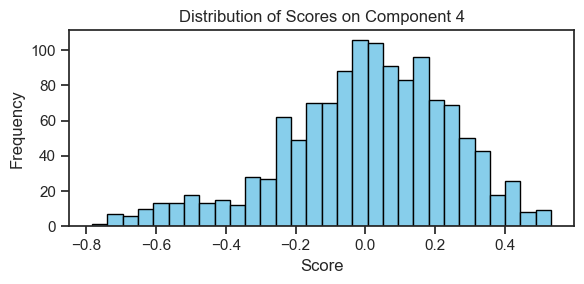

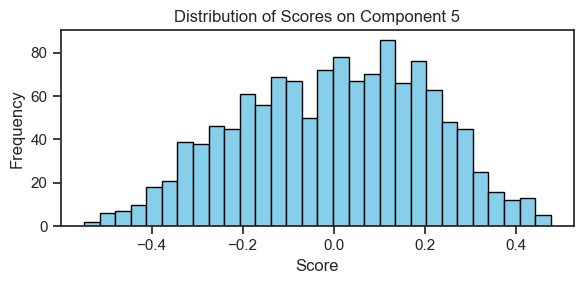

In [ ]:
scores = fpca.transform(fd)  # Shape: (N_samples, n_components)

for k in range(n_components_to_plot):
    plt.figure(figsize=(6, 3))
    plt.hist(scores[:, k], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of Scores on Component {k+1}")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
